### TFG - Cesar Hernandez Rodriguez

TFG escrito por César Hernández sobre la creacion de la frontera Eficiente y la optimización de carteras.

Este código tiene dos variantes, la variante "demo" que tiene solo 4 activos que son empresas conocidas $['AAPL','AMZN','FB','GOOGL']$ y luego tiene otro .csv con todos (o la mayoria) de las empresas que estan en el 
indice NASDAQ https://es.wikipedia.org/wiki/NASDAQ al cual se realiza una selección de k activos de forma aleatoria.

La descarga de los datos se realiza mediante una API de Python llamada Quandl, que descarga los datos de la página Web con el mismo nombre https://www.quandl.com/. Para poder recoger los datos hace falta registrarse y gracias a una clave se permite la descarga de ciertos archivos. Al tener la versión gratuita se limita mucho los datos por lo que he elegido un indice bastante grande como es el NASDAQ y los datos con los que se realiza la frontera eficiente son los datos desde 2012 hasta finales de 2015.

A parte se descarga los datos de 2016 para realizar una inversión ficticia con los resultados obtenidos.

Primero cargo los diferentes paquetes que voy a necesitar para realizar el algoritmo y cargo una paleta de colores.

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
import matplotlib.pyplot as plt
from time import time
import pickle
import random
import seaborn as sns
from matplotlib import cm
from matplotlib import colors
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')
np.random.seed(777)

#Grafico de bandera


Creo una función que recoja todos los datos que me permite descargar la API y que me interesen, para ello confronto dos csv uno con todos los datos de la API y otro con los activos que quiero para ver que todos estan y no hay problema. Se recogen los tickers de las empresas que se usaran en la API

In [2]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq(elec):
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    if elec == 0 :
        #tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols.csv')
        tickers_nasdaq = pd.read_csv('nasdaq-ejemplo.csv')  
    
    elif elec == 1 :
        tickers_nasdaq = pd.read_csv('nasdaq-tecnologicas.csv')
    
    elif elec == 2 :
        tickers_nasdaq = pd.read_csv('nasdaq-buenosconsumidores.csv')
    
    elif elec == 3 :
        tickers_nasdaq = pd.read_csv('nasdaq-financial.csv')
    
    elif elec == 4 :
        tickers_nasdaq = pd.read_csv('nasdaq-salud.csv')
        
    elif elec == 5 :
        tickers_nasdaq = pd.read_csv('nasdaq-todas.csv')
    

    
    #k = 6
    #tickers_nasdaq = tickers_nasdaq.sample(k)
    tickers_nasdaq = tickers_nasdaq.reset_index().drop(columns = "index")
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    tickers = tickers.dropna().reset_index().drop(columns = "index") # muchos no estan
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)

    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq(2)

A parte de descargar los datos los guardo serializados para que no ocupen mucho y no tener que estar descargando cada dos por tres los datos

In [3]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose,elec):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm' # Clave personal
    tickers, tickersQuandl = get_tickers_sample_nasdaq(elec)
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        aux=quandl.get(ticker,start_date="2012-01-01",end_date="2015-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-01-01",end_date="2017-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos/nasdaq_test.p", "wb"))
    pickle.dump(datosClose_test, open("datos/nasdaqClose_test.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [4]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos/nasdaq_test.p", "rb" ))
    datosClose_test = pickle.load(open("datos/nasdaqClose_test.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

Depende de si los datos los tengo descargados o no se pone la variable datos_descargados en True o False, si ya se tienen descargados se pone en True y si no se tienen en False

In [311]:
datos_descargados = False
elec = 5
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else: 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True,elec)
datosClose_pd = pd.DataFrame.from_dict(datosClose)
datosClose_test_pd = pd.DataFrame.from_dict(datosClose_test)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  8.333333333333332 % de los datos
LLeva descargados el  16.666666666666664 % de los datos
LLeva descargados el  25.0 % de los datos
LLeva descargados el  33.33333333333333 % de los datos
LLeva descargados el  41.66666666666667 % de los datos
LLeva descargados el  50.0 % de los datos
LLeva descargados el  58.333333333333336 % de los datos
LLeva descargados el  66.66666666666666 % de los datos
LLeva descargados el  75.0 % de los datos
LLeva descargados el  83.33333333333334 % de los datos
LLeva descargados el  91.66666666666666 % de los datos

Ha tardado en descargar los datos: 21.8766946793 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  8.333333333333332 % de los datos test
LLeva descargados el  16.666666666666664 % de los datos test
LLeva descargados el  25.0 % de los datos test
LLeva descargados el  33.33

Por un lado aqui se ve la variacion de precio durante los 4 años que se coge de modelo y sobre los datos test que se probaran mas tarde.

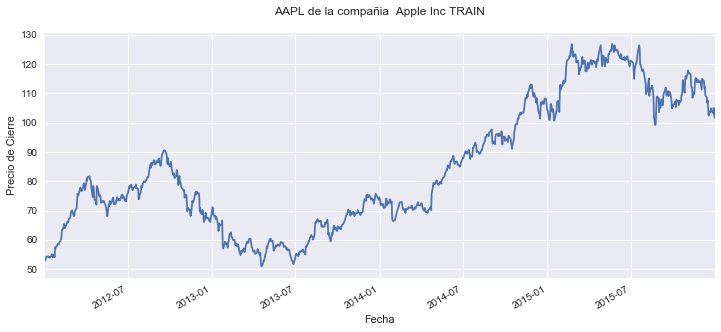

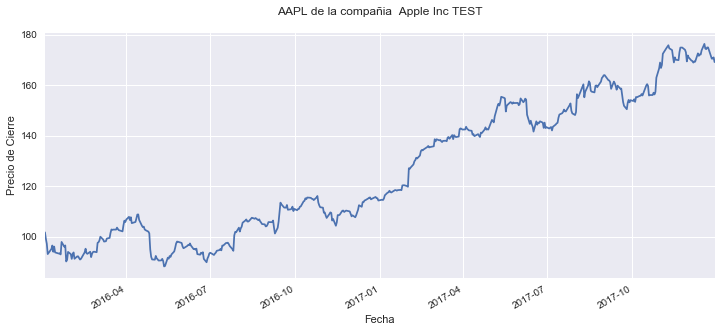

In [312]:
# Grafico un activo aleatorio que luego predecire
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
# ran = random.randint(0,len(tickers)-1)
ran = 0
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

Por otro lado vemos los valores de todas las empresas durante los datos de entrenamiento puestos en el mismo gráfico

Text(0, 0.5, 'price in $')

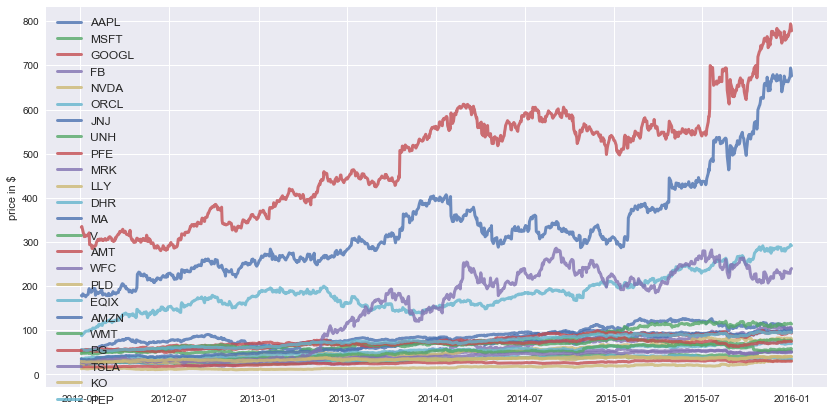

In [313]:
plt.figure(figsize=(14, 7))
for c in datosClose_pd.columns.values:
    plt.plot(datosClose_pd.index, datosClose_pd[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Y en gráficos separados, mirar a ver cuantos tickers tenemos para poder hacer el layout

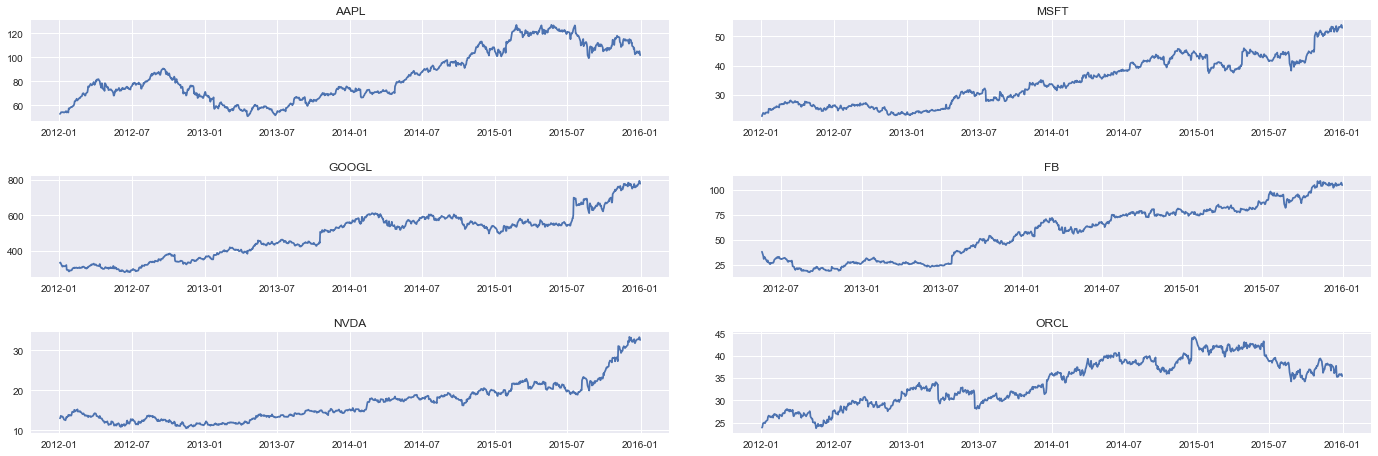

In [314]:
count=0
nrow = 3
ncol = 2
fig, axs = plt.subplots(nrow, ncol,figsize=(20, 7))
fig.tight_layout(pad=3.0)
for r in range(nrow):
    for c in range(ncol):
        axs[r, c].plot(datosClose_pd.index, datosClose_pd[datosClose_pd.columns.values[count]])
        axs[r, c].set_title(datosClose_pd.columns.values[count])
        count = count + 1

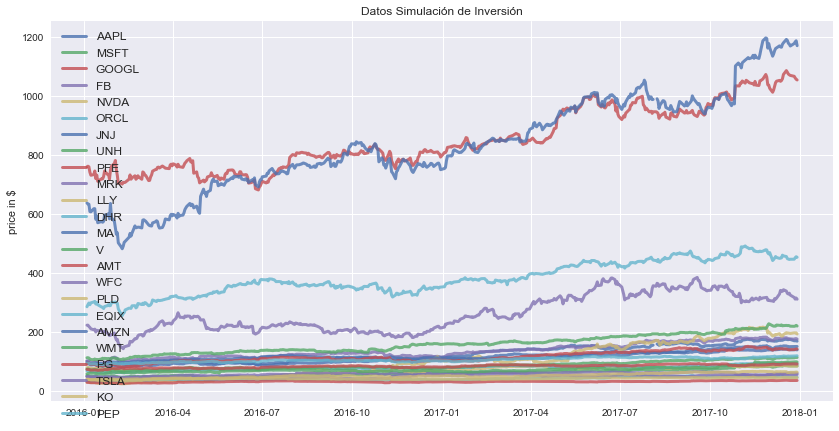

In [315]:
#TEST
plt.figure(figsize=(14, 7))
for c in datosClose_pd.columns.values:
    plt.plot(datosClose_test_pd.index, datosClose_test_pd[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.title("Datos Simulación de Inversión")
plt.ylabel('price in $')
plt.show()

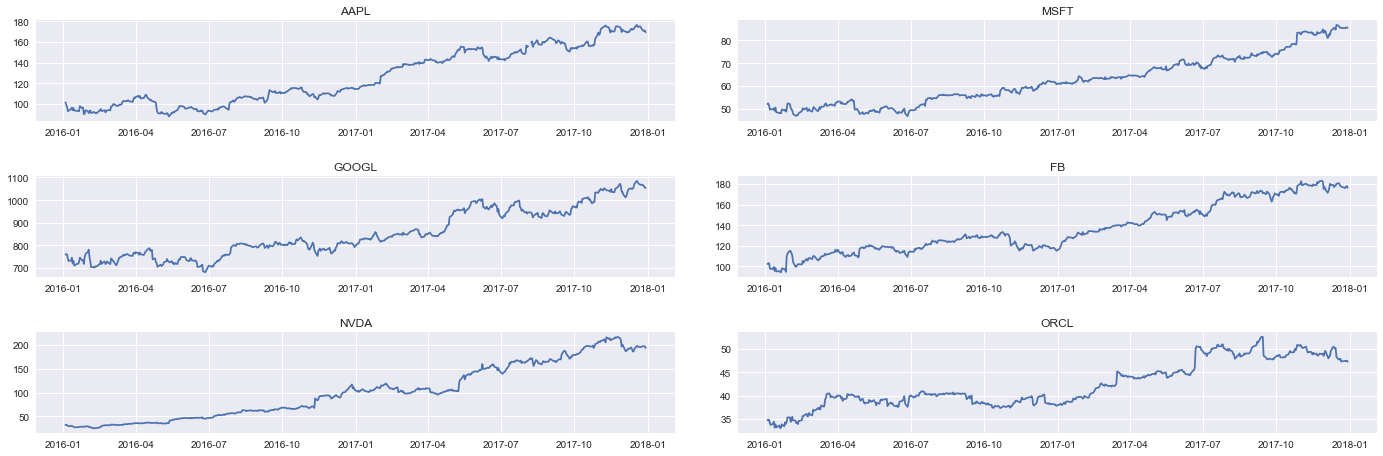

In [316]:
#TEST
count=0
nrow = 3
ncol = 2
fig, axs = plt.subplots(nrow, ncol,figsize=(20, 7))
fig.tight_layout(pad=3.0)
for r in range(nrow):
    for c in range(ncol):
        axs[r, c].plot(datosClose_test_pd.index, datosClose_test_pd[datosClose_pd.columns.values[count]])
        axs[r, c].set_title(datosClose_test_pd.columns.values[count])
        count = count + 1

Una parte muy importante a la hora de calcular la frontera eficiente son los retornos diarios de las empresas, el porcentaje de cambio que ha tenido una empresa de un dia para otro.

Text(0, 0.5, 'daily returns')

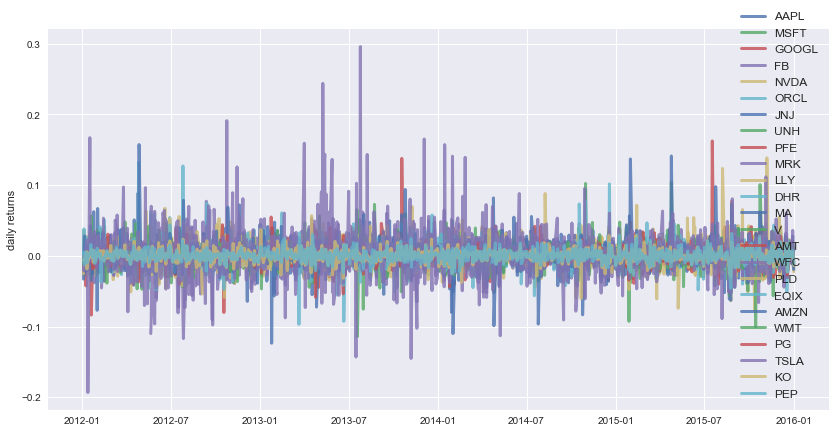

In [317]:
returns = datosClose_pd.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='lower right', fontsize=12)
plt.ylabel('daily returns')

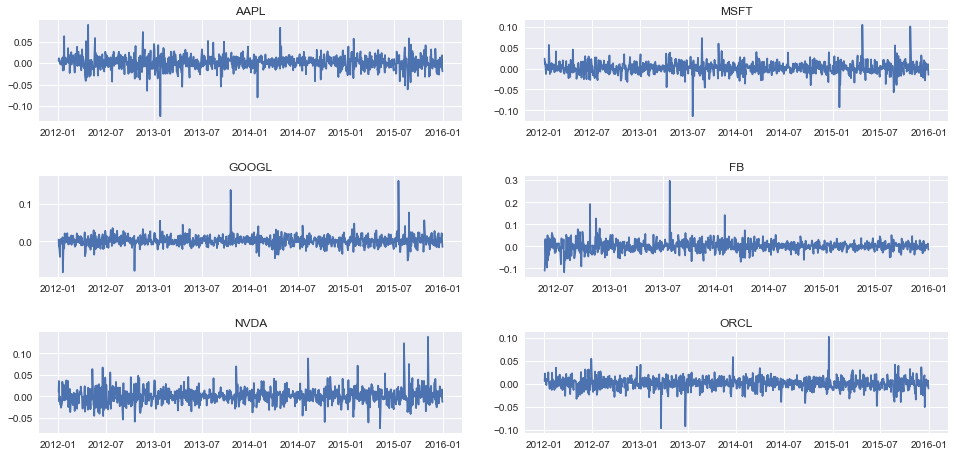

In [318]:
count=0
nrow = 3
ncol = 2
fig, axs = plt.subplots(nrow, ncol,figsize=(14, 7))
fig.tight_layout(pad=3.0)
for r in range(nrow):
    for c in range(ncol):
        axs[r, c].plot(datosClose_pd.index, returns[datosClose_pd.columns.values[count]])
        axs[r, c].set_title(datosClose_pd.columns.values[count])
        count = count + 1

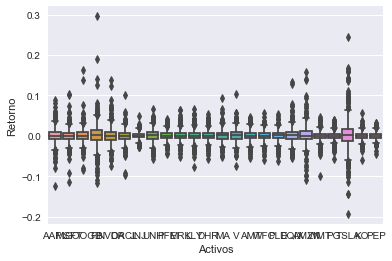

In [319]:
sns.boxplot(x="variable", y="value", data=pd.melt(returns)).set(
    xlabel='Activos', 
    ylabel='Retorno'
)
plt.show()

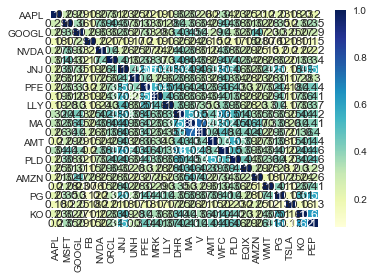

In [320]:
fig, ax = plt.subplots()
sns.heatmap(returns.corr(),annot=True, linewidths=.5, cmap="YlGnBu")
ax.set_ylim(len(returns.corr())-0.0, -0.0)
plt.show()

## Metodo MonteCarlo

Antes de realizar una frontera eficiente mediante la optimizacion de carteras vamos a realizar mediante un metodo de MonteCarlo, se basa en realiar muchas pruebas a muchas carteras diferentes con % de distribucion de dinero aleatorias a cada cartera y asi ver sobre un grafico como quedarian las carpetas bajo los ejes de rentabilidad y riesgo (o volatibidad), buscamos la cartera con minimo riesgo y la cartera con máximo valor de Ratio Sharpe

In [321]:
# Calculo de el rendimiento esperado y volatibilidad esperada de una cartera
# Aqui tengo dudas ya que no se si multiplciar por 252 y si en la desviacion hacer la raiz cuadrada
def rendimiento_portfolio(pesos, medias_retorno, cov_retorno):
    # 252 dias esta abierta la bolsa a lo largo del año
    # Tengo dudas sobre esto del 252 para el rendimiento anualizado preguntar Ricardo
    retorno = np.sum(medias_retorno*pesos) * 252
    std = np.sqrt(np.dot(pesos.T, np.dot(cov_retorno, pesos))) * 252
    return retorno, std

# risk free rate indece NASDAQ = 0.71000000
def portfolios_aleatorios(num,medias_retorno,cov_retorno,risk_free_rate):
    pruebas = np.zeros((3,num))
    pesos_matriz = []
    for i in range(num):
        # Creo pesos aleatorios
        pesos = np.random.random(len(medias_retorno))
        pesos = pesos/sum(pesos)
        pesos_matriz.append(pesos)
        retorno_port, std_port = rendimiento_portfolio(pesos, medias_retorno, cov_retorno)
        pruebas[0,i] = std_port
        pruebas[1,i] = retorno_port
        pruebas[2,i] = (retorno_port - risk_free_rate) / std_port # ratio sharpe
    return pruebas, pesos_matriz

#Ahora simulo todas las carpetas en hago un grafico con todas
def simulacion(medias_retorno, cov_retorno, num, risk_free_rate):
    pruebas, pesos = portfolios_aleatorios(num, medias_retorno, cov_retorno, risk_free_rate)
    
    index_max_shape = np.argmax(pruebas[2])
    std_sharpe, ret_sharpe = pruebas[0,index_max_shape], pruebas[1,index_max_shape]
    reparto_sharpe = pd.DataFrame(pesos[index_max_shape],index = datosClose_pd.columns, columns = ['reparto'])
    reparto_sharpe.reparto = [round(100*i,3) for i in reparto_sharpe.reparto]
    reparto_sharpe = reparto_sharpe.T
    
    index_min_vol = np.argmin(pruebas[0])
    std_vol, ret_vol = pruebas[0,index_min_vol], pruebas[1,index_min_vol]
    reparto_vol = pd.DataFrame(pesos[index_min_vol],index = datosClose_pd.columns, columns = ['reparto'])
    reparto_vol.reparto = [round(100*i,3) for i in reparto_vol.reparto]
    reparto_vol = reparto_vol.T
    
    print ("-"*80)
    print ("Reparto de Dinero en % Maximo Sharpe\n")
    print ("Retorno anualizado:", round(ret_sharpe,3))
    print ("Volatilidad anualizada:", round(std_sharpe,3))
    print ("\n")
    print (reparto_sharpe)
    print ("-"*80)
    print ("Reparto de Dinero en % de Minima Volatilidad\n")
    print ("Retorno anualizado:", round(ret_vol,3))
    print ("Volatilidad anualizada:", round(std_vol,3))
    print ("\n")
    print (reparto_vol)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(pruebas[0,:],pruebas[1,:],c=pruebas[2,:],cmap='PuBuGn', marker='o', s=10, alpha=0.3)
    plt.colorbar(label="Sharpe ratio")
    #plt.scatter(std_sharpe,ret_sharpe,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    #plt.scatter(std_vol,ret_vol,marker='*',color='b',s=500, label=' Minima Volatilidad')
    plt.title('Simulacion de Carteras y Creacion de Frontera Eficiente')
    plt.xlabel('Volatilidad Anual Esperada')
    plt.ylabel('Retorno Anual Esperado')
    plt.legend(labelspacing=0.8)

In [322]:
retorno = datosClose_pd.pct_change()
retorno = retorno[1:len(returns)]
medias_retorno = retorno.mean()
cov_retorno = retorno.cov()
num_portfolio = 200000
risk_free_rate = 0.0178
#risk_free_rate = 0.0

--------------------------------------------------------------------------------
Reparto de Dinero en % Maximo Sharpe

Retorno anualizado: 0.282
Volatilidad anualizada: 2.349


          AAPL   MSFT  GOOGL     FB   NVDA   ORCL    JNJ    UNH    PFE    MRK  \
reparto  4.248  1.339  2.855  5.001  6.084  0.554  2.169  9.853  4.671  1.533   

         ...    AMT    WFC    PLD   EQIX   AMZN    WMT     PG   TSLA     KO  \
reparto  ...  7.022  0.964  2.923  8.401  5.353  1.486  2.017  8.679  1.246   

           PEP  
reparto  1.212  

[1 rows x 24 columns]
--------------------------------------------------------------------------------
Reparto de Dinero en % de Minima Volatilidad

Retorno anualizado: 0.169
Volatilidad anualizada: 1.853


          AAPL   MSFT  GOOGL     FB   NVDA   ORCL    JNJ    UNH    PFE    MRK  \
reparto  2.151  0.453    3.6  2.417  2.541  2.746  5.955  0.394  9.335  7.564   

         ...    AMT    WFC   PLD   EQIX   AMZN    WMT     PG   TSLA     KO  \
reparto  ...  5.47

No handles with labels found to put in legend.


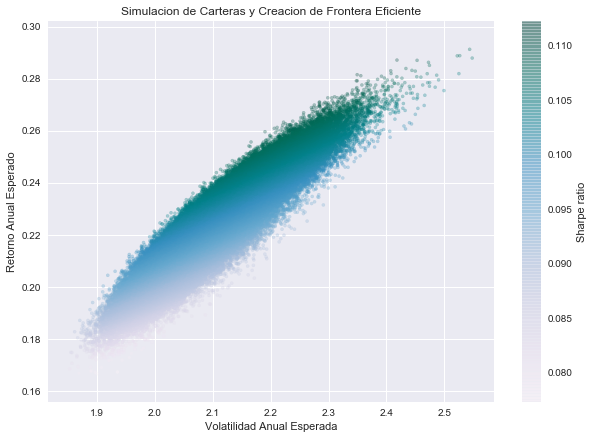

In [17]:
simulacion(medias_retorno, cov_retorno, num_portfolio, risk_free_rate)

## Frontera eficiente

Para calcular la frontera eficiente y calcular carteras optimizadas uso el paquete scipy que me permite optimizar funciones, mediante la minimizacion, para ello quiero 3 cosas, la cartera con maximo ratio sharpe, es decir la cartera con minimo menos ratio sharpe, la cartera de minimo riesgo y la frontera eficiente.

In [323]:
# funcion que calcula el rendimiento con un mu especifico
def portfolio_mu(pesos, medias_retorno, cov_retorno, mu):
    retorno_port, std_port = rendimiento_portfolio(pesos, medias_retorno, cov_retorno)
    return mu * std_port - retorno_port

# optimizacion de la cartera con minima volatibilidad
def min_mu(medias_retorno, cov_retorno,mu):
    num_activos = len(medias_retorno)
    args = (medias_retorno, cov_retorno, mu)
    res = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    lim = (0.0,1.0)
    lims = tuple(lim for activo in range(num_activos))

    result = sco.minimize(portfolio_mu, num_activos*[1./num_activos,], args=args,
                        method='SLSQP', bounds=lims, constraints=res)

    return result

def neg_sharpe_ratio(pesos, medias_retorno, cov_retorno, risk_free_rate):
    p_ret, p_var = rendimiento_portfolio(pesos, medias_retorno, cov_retorno)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(medias_retorno, cov_retorno, risk_free_rate):
    num_assets = len(medias_retorno)
    args = (medias_retorno, cov_retorno, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(pesos, medias_retorno, cov_retorno):
    return rendimiento_portfolio(pesos, medias_retorno, cov_retorno)[1]

def min_varianza(medias_retorno, cov_retorno):
    num_assets = len(medias_retorno)
    args = (medias_retorno, cov_retorno)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(medias_retorno, cov_retorno, target):
    num_assets = len(medias_retorno)
    args = (medias_retorno, cov_retorno)

    def portfolio_return(pesos):
        return rendimiento_portfolio(pesos, medias_retorno, cov_retorno)[0]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def frontera_eficiente(medias_retorno, cov_retorno, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(medias_retorno, cov_retorno, ret))
    return efficients

Tambien se puede representar como quedarian en terminos de rendimiento y riesgo estas carteras comparado con lo que pasaria si meteriamos todo a un mismo activo

In [324]:
def simulacion_frontera_eficiente_indv(medias_retorno, cov_retorno, num_portfolios, risk_free_rate, mu):
    results, _ = portfolios_aleatorios(num_portfolios,medias_retorno, cov_retorno, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(medias_retorno, cov_retorno, risk_free_rate)
    ret_sharpe, std_sharpe = rendimiento_portfolio(max_sharpe['x'], medias_retorno, cov_retorno)
    reparto_sharpe = pd.DataFrame(max_sharpe.x,index=datosClose_pd.columns,columns=['reparto'])
    reparto_sharpe.reparto = [round(i*100,4)for i in reparto_sharpe.reparto]
    reparto_sharpe = reparto_sharpe.T

    min_vol = min_varianza(medias_retorno, cov_retorno)
    ret_vol, std_vol = rendimiento_portfolio(min_vol['x'], medias_retorno, cov_retorno)
    reparto_vol = pd.DataFrame(min_vol.x,index=datosClose_pd.columns,columns=['reparto'])
    reparto_vol.reparto = [round(i*100,4)for i in reparto_vol.reparto]
    reparto_vol = reparto_vol.T
    
    mu_port = min_mu(medias_retorno, cov_retorno, mu)
    ret_mu, std_mu = rendimiento_portfolio(mu_port['x'], medias_retorno, cov_retorno)
    reparto_mu = pd.DataFrame(mu_port.x,index=datosClose_pd.columns,columns=['reparto'])
    reparto_mu.reparto = [round(i*100,4)for i in reparto_mu.reparto]
    reparto_mu = reparto_mu.T
    
    equi = np.array([1/24]*24) #Cambiar al numero de activos que se tenga para cartera equitativa
    ret_equi, std_equi = rendimiento_portfolio(equi, medias_retorno, cov_retorno)
    reparto_equi = pd.DataFrame(equi,index=datosClose_pd.columns,columns=['reparto'])
    reparto_equi.reparto = [round(i*100,4)for i in reparto_equi.reparto]
    reparto_equi = reparto_equi.T
    
    anual_vol = np.std(retorno) * 252 #o sqrt segun como lo haya hecho
    anual_ret = medias_retorno * 252
    
    print ("-"*80)
    print ("Reparto de Dinero en % Maximo Sharpe\n")
    print ("Rentabilidad anualizado:", round(ret_sharpe,3))
    print ("Volatilidad anualizada:", round(std_sharpe,3))
    print ("\n")
    print (reparto_sharpe)
    print ("-"*80)
    print ("Reparto de Dinero en % de Minima Volatilidad\n")
    print ("Rentabilidad anualizado:", round(ret_vol,3))
    print ("Volatilidad anualizada:", round(std_vol,3))
    print ("\n")
    print (reparto_vol)
    print ("-"*80)
    print ("Reparto de Dinero en % Con un Mu =", mu,"\n")
    print ("Rentabilidad anualizado:", round(ret_mu,3))
    print ("Volatilidad anualizada:", round(std_mu,3))
    print ("\n")
    print (reparto_mu)
    print ("-"*80)
    print ("Reparto de Dinero en % de Equidistante\n")
    print ("Rentabilidad anualizado:", round(ret_equi,3))
    print ("Volatilidad anualizada:", round(std_equi,3))
    print ("\n")
    print (reparto_equi,3)
    print ("-"*80)
    print ("Rentabilidad y Riesgo Individual\n")
    for i, txt in enumerate(datosClose_pd.columns):
        print (txt,":","Rentabilidad anualizado",round(anual_ret[i],2),", Volatilidad anualizada:",round(anual_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='PuBuGn', marker='o', s=10, alpha=0.3)
    ax.scatter(anual_vol,anual_ret,marker='o',s=200)
    
    
    for i, txt in enumerate(datosClose_pd.columns):
        ax.annotate(txt, (anual_vol[i],anual_ret[i]), xytext=(10,0), textcoords='offset points')
    plt.scatter(std_sharpe,ret_sharpe,marker='*',color='r',s=500, label='Ratio Sharpe Maximo')
    plt.scatter(std_vol,ret_vol,marker='*',color='g',s=500, label='Riesgo Minimo')
    plt.scatter(std_mu,ret_mu,marker='*',color='b',s=500, label='Máxima Rentabilidad')

    target = np.linspace(ret_vol, anual_ret.max(),50)
    efficient_portfolios = frontera_eficiente(medias_retorno, cov_retorno, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.scatter(std_equi,ret_equi,marker='*',color='black',s=500, label='Equiponderada')
    ax.set_title('Optimización de Carteras Sector de la Salud')
    plt.xlabel('Volatilidad anualizada')
    plt.ylabel('Rentabilidad anualizado')
    ax.legend(labelspacing=0.8)
    
    return reparto_sharpe,reparto_vol,reparto_mu, reparto_equi



--------------------------------------------------------------------------------
Reparto de Dinero en % Maximo Sharpe

Rentabilidad anualizado: 0.333
Volatilidad anualizada: 2.606


         AAPL    MSFT  GOOGL      FB    NVDA  ORCL  JNJ      UNH  PFE  MRK  \
reparto   0.0  2.1239    0.0  4.7225  2.9717   0.0  0.0  13.8511  0.0  0.0   

         ...  AMT  WFC  PLD     EQIX   AMZN  WMT   PG     TSLA   KO     PEP  
reparto  ...  0.0  0.0  0.0  14.2926  9.704  0.0  0.0  12.2276  0.0  7.1622  

[1 rows x 24 columns]
--------------------------------------------------------------------------------
Reparto de Dinero en % de Minima Volatilidad

Rentabilidad anualizado: 0.125
Volatilidad anualizada: 1.698


           AAPL  MSFT   GOOGL      FB    NVDA    ORCL      JNJ    UNH     PFE  \
reparto  3.7653   0.0  1.0288  0.8425  1.9663  0.1785  16.6994  2.435  5.7451   

            MRK  ...     AMT  WFC  PLD  EQIX  AMZN      WMT       PG  TSLA  \
reparto  1.9169  ...  4.0563  0.0  0.0   0.0   0.0 

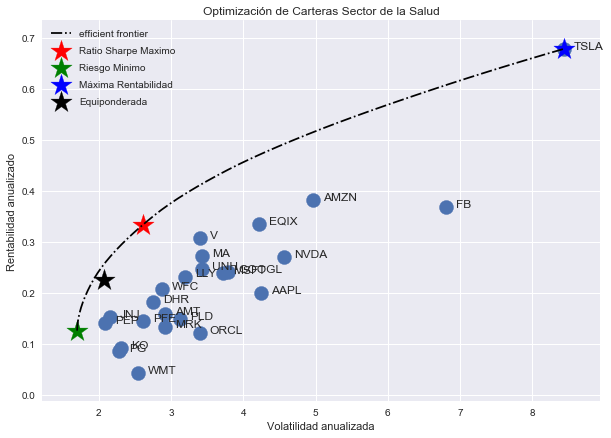

In [325]:
mu = 0
num_portfolio = 0
reparto_sharpe,reparto_vol,reparto_mu, reparto_equi = simulacion_frontera_eficiente_indv(medias_retorno, cov_retorno,num_portfolio, risk_free_rate, mu)

El caso de abajo es para quitar los casos en los que algun activo tenga 0%

In [351]:
reparto = reparto_sharpe
labels = list(reparto.columns[reparto.values[0]>0])
sizes = reparto.values[0][reparto.values[0]>0]
explode = np.array([0.00]*len(labels))
colores = ['#800000', '#000080', '#006400', '#800080', '#8B4513', '#2F4F4F','#228B22', '#FF4500', '#C71585', '#D2B48C', '#B8860B', '#00FF00','#3399CC', '#FF6666', '#DB7093', '#F0D58C', '#1E90FF', '#DDA0DD','#ADFF2F', '#D2B48C', '#708090', '#6B8E23', '#C71585', '#FF4500']
#colores = ['#DDA0DD','#ADFF2F', '#D2B48C', '#708090', '#6B8E23', '#C71585']
colores = random.sample(colores, len(labels))
#colores = ['#6B8E23','#ADFF2F','#D2B48C','#C71585']

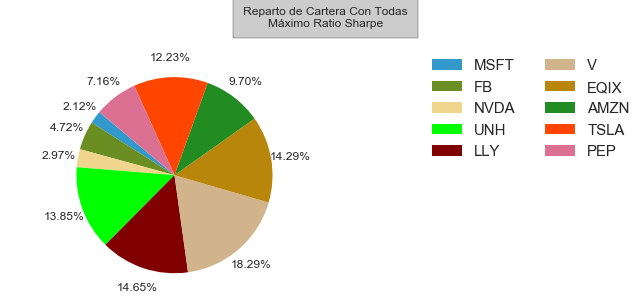

In [353]:
mpl.rcParams['font.size'] = 12.0
patches, texts, auto= plt.pie(sizes, colors=colores, autopct=lambda p: '{:1.2f}%'.format(round(p,4)) if p > 0 else '', startangle=140, center = (0,-0.1), pctdistance = 1.2, explode=explode)
plt.legend(patches, labels, loc="best", prop={"size":15},bbox_to_anchor=(1.9, 1.1), ncol=2)
plt.axis('equal')
#plt.tight_layout()
plt.title("Reparto de Cartera Con Todas\n" + "Máximo Ratio Sharpe", bbox={'facecolor':'0.8', 'pad':10}, y=1.16, x=0.95)
#plt.title("Reparto de Cartera Con Todas\n" + "Mínimo Riesgo", bbox={'facecolor':'0.8', 'pad':10}, y=1.16, x=0.95)
#plt.title("Reparto de Cartera Con Todas\n" + "Máxima Rentabilidad", bbox={'facecolor':'0.8', 'pad':10}, y=1.16, x=0.75)
#plt.title("Reparto de Cartera Con Todas\n" + "Equitativa", bbox={'facecolor':'0.8', 'pad':10}, y=1.16, x=0.95)
plt.show()

In [38]:
acciones_sharpe = round(100000 * reparto_sharpe / 100,0).replace([np.inf, -np.inf], 0)
acciones_sharpe = round(acciones_sharpe/datosClose_test_pd.iloc[0],0)
acciones_vol = round(100000 * reparto_vol / 100,0).replace([np.inf, -np.inf], 0)
acciones_vol = round(acciones_vol/datosClose_test_pd.iloc[0],0)
acciones_mu = round(100000 * reparto_mu / 100,0).replace([np.inf, -np.inf], 0)
acciones_mu = round(acciones_mu/datosClose_test_pd.iloc[0],0)
acciones_equi = round(100000 * reparto_equi / 100,0).replace([np.inf, -np.inf], 0)
acciones_equi = round(acciones_equi/datosClose_test_pd.iloc[0],0)

In [39]:
acciones = {'Max_rend' : acciones_mu, 'Max_Sharpe' : acciones_sharpe, 'Min_riesgo' : acciones_vol, 'Equitativa' : acciones_equi}
ganancias = pd.DataFrame(columns = acciones.keys())
for cartera in acciones.keys():
    ganancias_activo = datosClose_test_pd.iloc[0:len(datosClose_test_pd)].multiply(acciones[cartera].values,axis=1)
    ganancias_dia = ganancias_activo.sum(axis=1) - 100000
    ganancias[cartera] = ganancias_dia

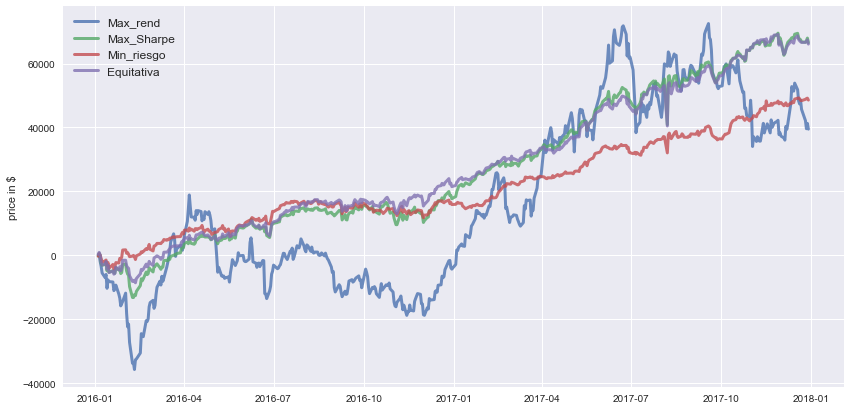

In [40]:
plt.figure(figsize=(14, 7))
for c in ganancias.columns.values:
    plt.plot(ganancias.index, ganancias[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')
plt.show()

### Indice NASDAQ100

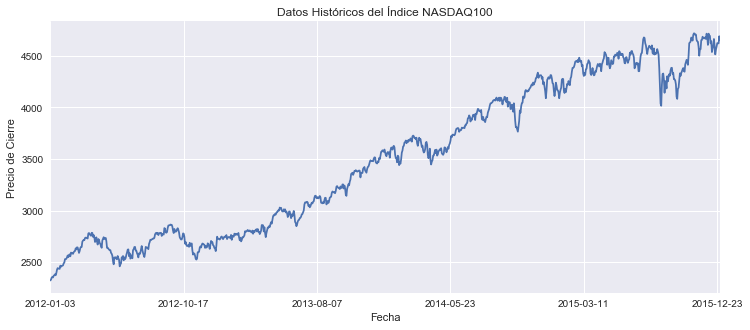

In [56]:
NDX = pd.read_csv('NDX100Train.csv')
NDX = NDX.set_index('Date')
NDX_close = NDX["Adj Close"]
NDX_close.plot(figsize=(12,5),grid=True)
plt.title('Datos Históricos del Índice NASDAQ100')
plt.ylabel('Precio de Cierre')
plt.xlabel('Fecha')
plt.show()

In [197]:
porc_sharpe_todas = pd.DataFrame(reparto_sharpe.divide(reparto_sharpe.sum(axis=1),axis=0).values,index = ['todas'],columns = reparto_sharpe.columns)
porc_sharpe_salud = pd.DataFrame([{"JNJ":0.18,"UNH":0.3,"LLY":0.32,"DHR":0.2}],index=['salud'])
porc_sharpe_serfin = pd.DataFrame([{"MA":0.02,"EQIX":0.3,"WFC":0.2,"V":0.48}],index=['serfin'])
porc_sharpe_cons = pd.DataFrame([{"PEP":0.51,"TSLA":0.21,"AMZN":0.28}],index=['cons'])
porc_sharpe_tec = pd.DataFrame([{"GOOGL":0.25,"FB":0.16,"MSFT":0.29,"AAPL":0.12,"NVDA":0.18}],index=['tec'])

porc_sharpe = porc_sharpe_todas.append(porc_sharpe_salud,sort=True).fillna(0)
porc_sharpe = porc_sharpe.append(porc_sharpe_serfin,sort=True).fillna(0)
porc_sharpe = porc_sharpe.append(porc_sharpe_cons,sort=True).fillna(0)
porc_sharpe = porc_sharpe.append(porc_sharpe_tec,sort=True).fillna(0)

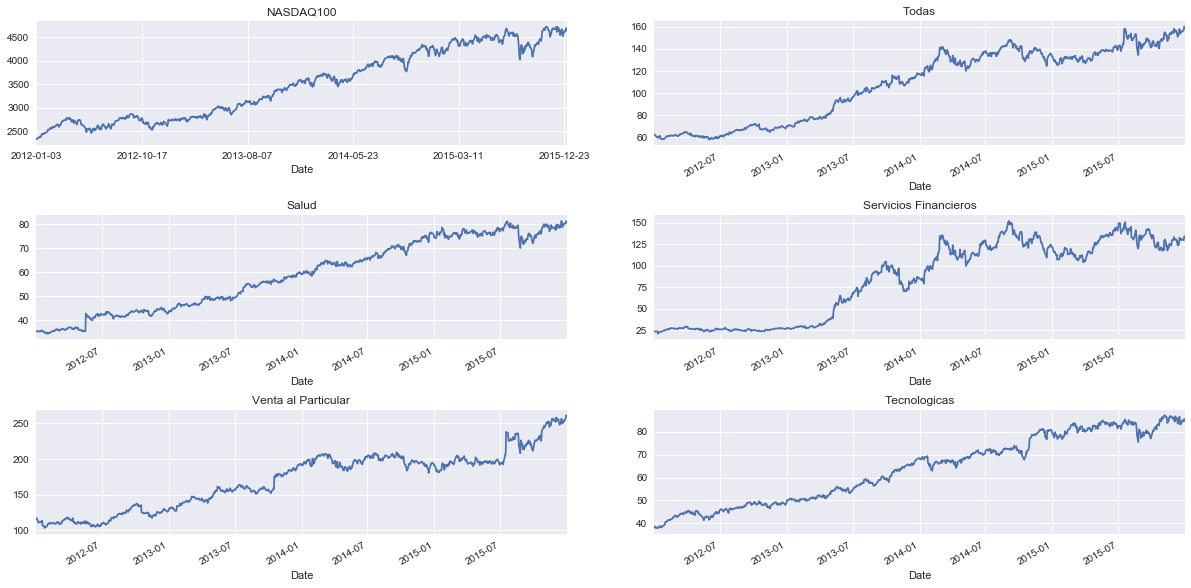

In [198]:
valores_todas = pd.Series(datosClose_pd.iloc[0:len(datosClose_pd)-1].multiply(porc_sharpe.iloc[0].values,axis=1).sum(axis=1))
valores_salud = pd.Series(datosClose_pd.iloc[0:len(datosClose_pd)-1].multiply(porc_sharpe.iloc[1].values,axis=1).sum(axis=1))
valores_serfin = pd.Series(datosClose_pd.iloc[0:len(datosClose_pd)-1].multiply(porc_sharpe.iloc[2].values,axis=1).sum(axis=1))
valores_cons = pd.Series(datosClose_pd.iloc[0:len(datosClose_pd)-1].multiply(porc_sharpe.iloc[3].values,axis=1).sum(axis=1))
valores_tec = pd.Series(datosClose_pd.iloc[0:len(datosClose_pd)-1].multiply(porc_sharpe.iloc[4].values,axis=1).sum(axis=1))

nrow = 3
ncol = 2
fig, axs = plt.subplots(nrow, ncol,figsize=(18, 10))
fig.tight_layout(pad=5.0)
NDX_close.plot(ax=axs[0,0]) ; axs[0,0].set_title('NASDAQ100')
valores_todas.plot(ax=axs[0,1]) ; axs[0,1].set_title('Todas')
valores_salud.plot(ax=axs[1,0]) ; axs[1,0].set_title('Salud')
valores_serfin.plot(ax=axs[1,1]) ; axs[1,1].set_title('Servicios Financieros')
valores_cons.plot(ax=axs[2,0]) ; axs[2,0].set_title('Venta al Particular')
valores_tec.plot(ax=axs[2,1]) ; axs[2,1].set_title('Tecnologicas')
plt.show()


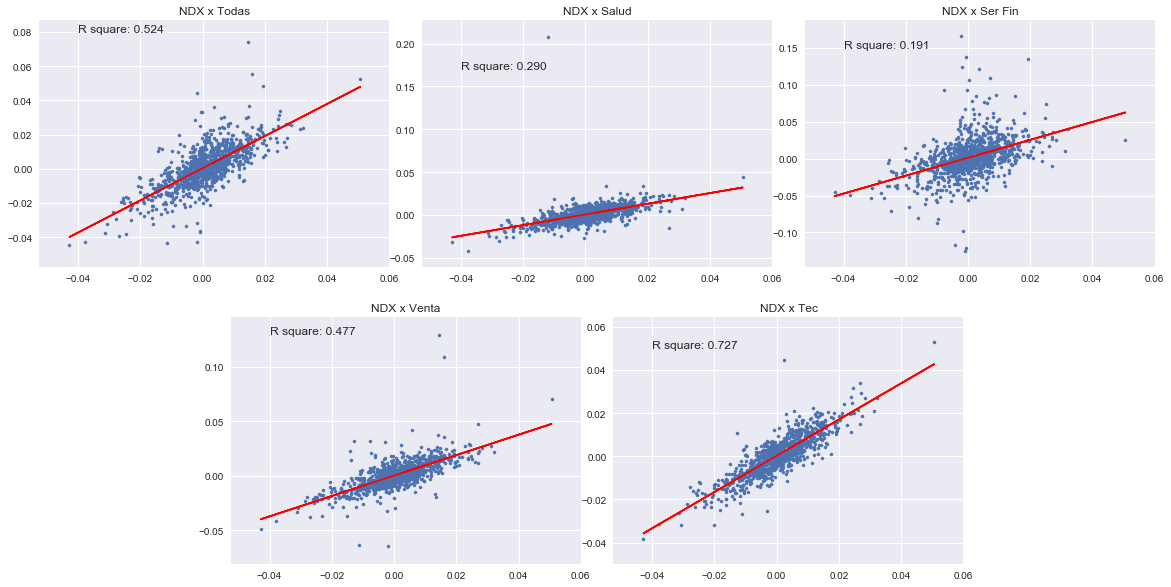

In [288]:
# Retornos diarios
NDX_ret = NDX_close.pct_change()[1:len(NDX_close)].iloc[:].values.reshape(-1,1)
valores_todas_ret = valores_todas.pct_change()[1:len(valores_todas)].iloc[:].values.reshape(-1,1)
valores_salud_ret = valores_salud.pct_change()[1:len(valores_salud)].iloc[:].values.reshape(-1,1)
valores_serfin_ret = valores_serfin.pct_change()[1:len(valores_serfin)].iloc[:].values.reshape(-1,1)
valores_cons_ret = valores_cons.pct_change()[1:len(valores_cons)].iloc[:].values.reshape(-1,1)
valores_tec_ret = valores_tec.pct_change()[1:len(valores_tec)].iloc[:].values.reshape(-1,1)

# Regresiones lineales 
NDX_todas = LinearRegression().fit(NDX_ret,valores_todas_ret)
NDX_todas_pred = NDX_todas.predict(NDX_ret) ; r_sq_todas = NDX_todas.score(NDX_ret,valores_todas_ret)

NDX_salud = LinearRegression().fit(NDX_ret,valores_salud_ret)
NDX_salud_pred = NDX_salud.predict(NDX_ret) ; r_sq_salud = NDX_salud.score(NDX_ret,valores_salud_ret)

NDX_serfin = LinearRegression().fit(NDX_ret,valores_serfin_ret)
NDX_serfin_pred = NDX_serfin.predict(NDX_ret) ; r_sq_serfin = NDX_serfin.score(NDX_ret,valores_serfin_ret)

NDX_cons = LinearRegression().fit(NDX_ret,valores_cons_ret)
NDX_cons_pred = NDX_cons.predict(NDX_ret) ; r_sq_cons = NDX_cons.score(NDX_ret,valores_cons_ret)

NDX_tec = LinearRegression().fit(NDX_ret,valores_tec_ret)
NDX_tec_pred = NDX_tec.predict(NDX_ret) ; r_sq_tec = NDX_tec.score(NDX_ret,valores_tec_ret)

plt.figure(figsize=(20,10))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

ax1.scatter(NDX_ret, valores_todas_ret,s=10) ; ax1.plot(NDX_ret, NDX_todas_pred, color='red') ; ax1.set_title('NDX x Todas')
ax1.annotate("R square: %.3f" %round(r_sq_todas,3), xy=(0, 0), xytext=(-0.04, 0.08))
ax2.scatter(NDX_ret, valores_salud_ret,s=10) ; ax2.plot(NDX_ret, NDX_salud_pred, color='red') ; ax2.set_title('NDX x Salud')
ax2.annotate("R square: %.3f" %round(r_sq_salud,3), xy=(0, 0), xytext=(-0.04, 0.17))
ax3.scatter(NDX_ret, valores_serfin_ret,s=10) ; ax3.plot(NDX_ret, NDX_serfin_pred, color='red') ; ax3.set_title('NDX x Ser Fin')
ax3.annotate("R square: %.3f" %round(r_sq_serfin,3), xy=(0, 0), xytext=(-0.04, 0.15))
ax4.scatter(NDX_ret, valores_cons_ret,s=10) ; ax4.plot(NDX_ret, NDX_cons_pred, color='red') ; ax4.set_title('NDX x Venta')
ax4.annotate("R square: %.3f" %round(r_sq_cons,3), xy=(0, 0), xytext=(-0.04, 0.13))
ax5.scatter(NDX_ret, valores_tec_ret,s=10) ; ax5.plot(NDX_ret, NDX_tec_pred, color='red') ; ax5.set_title('NDX x Tec')
ax5.annotate("R square: %.3f" %round(r_sq_tec,3), xy=(0, 0), xytext=(-0.04, 0.05))

plt.show()

In [ ]:
import statsmodels.api as sm

In [308]:
x = sm.add_constant(NDX_ret)
model = sm.OLS(valores_todas_ret, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     1101.
Date:                Fri, 11 Sep 2020   Prob (F-statistic):          1.78e-163
Time:                        18:45:34   Log-Likelihood:                 3363.6
No. Observations:                1004   AIC:                            -6723.
Df Residuals:                    1002   BIC:                            -6713.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.189      0.2

In [307]:
#print(results.summary().as_latex())

In [316]:
print("Todas: ",valores_todas_ret.std() - 0.94**2*NDX_ret.std())
print("Salud: ",valores_salud_ret.std() - 0.62**2*NDX_ret.std())
print("SerFin: ",valores_serfin_ret.std() - 1.21**2*NDX_ret.std())
print("Cons: ",valores_cons_ret.std() - 0.93**2*NDX_ret.std())
print("Tec: ",valores_tec_ret.std() - 0.83**2*NDX_ret.std())

Todas:  0.003935110903345982
Salud:  0.0073123381537339325
SerFin:  0.012458603828526411
Cons:  0.004637735605987287
Tec:  0.0027841620980383662
